In [68]:
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
import statsmodels.stats.proportion as proportion
import statsmodels.stats.power as smp
import bootstrapped.bootstrap as bs
import bootstrapped.stats_functions as bs_stats
import bootstrapped.compare_functions as bs_compare

## Выберем окно конверсии, используя исторические данные 
**1. Прочитаем файл investigate_window.csv.**


In [2]:
historical_data = pd.read_csv('investigate_window.csv', parse_dates = [1,2])

In [3]:
historical_data.head()

,Unnamed: 0,user_id,main_page_viewed_at,order_completed_at,time_to_order
0,0,959238,2020-11-20 23:55:02.759000+00:00,2020-11-30 02:22:32.759000+00:00,9.102431
1,1,337366,2020-12-05 23:41:42.244000+00:00,2020-12-12 22:25:52.244000+00:00,6.947338
2,2,259956,2020-11-20 23:33:53.269000+00:00,2020-11-25 13:08:03.269000+00:00,4.565394
3,3,534280,2020-11-28 23:44:56.556000+00:00,2020-12-05 10:14:06.556000+00:00,6.436921
4,4,795121,2020-11-18 23:59:56.236000+00:00,2020-11-27 02:38:16.236000+00:00,8.109954


In [49]:
historical_data.dtypes


Unnamed: 0                           int64
user_id                             object
main_page_viewed_at    datetime64[ns, UTC]
order_completed_at                  object
time_to_order                      float64
dtype: object

**2. Вычислим 95, 90 и 85 перцентили для наших данных с помощью колонки time_to_order.**

In [8]:
perc_85 = round(np.percentile(historical_data['time_to_order'], 85),1)
perc_85

2.0

In [7]:
perc_90 = round(np.percentile(historical_data['time_to_order'], 90),1)
perc_90

2.9

In [6]:
perc_95 = round(np.percentile(historical_data['time_to_order'], 95),1)
perc_95

7.1

**3. Построим гистограмму распределения времени между первым заходом на сайт и покупкой.** 

C:\Users\1645295\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


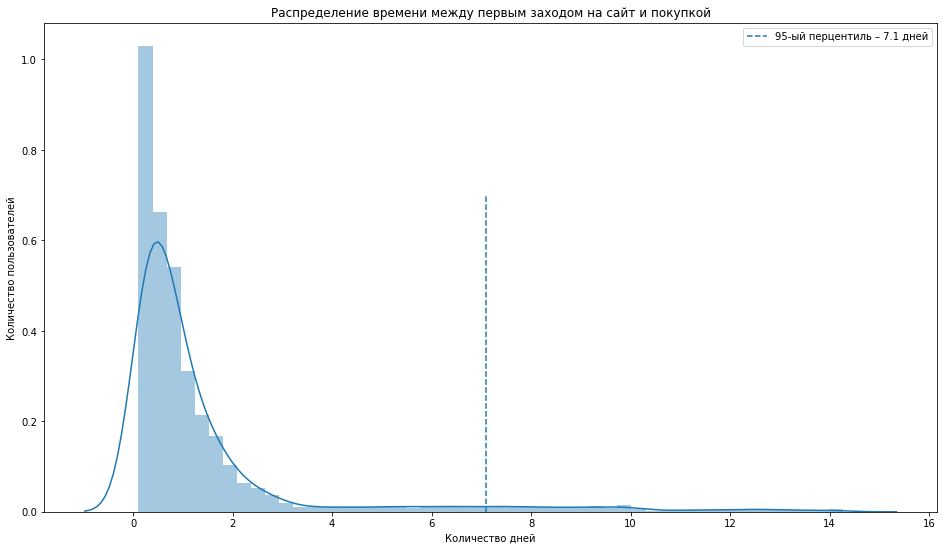

In [ ]:
# напиши здесь код
plt.figure(figsize=(16,9))
sns.distplot(historical_data['time_to_order'])
plt.vlines(perc_95, ymin = 0, ymax = 0.7, linestyles = 'dashed', label = f'95-ый перцентиль – {perc_95} дней')
plt.title('Распределение времени между первым заходом на сайт и покупкой')
plt.xlabel('Количество дней')
plt.ylabel('Количество пользователей')
plt.legend()
plt.show()

## Исследуем распределение пользователей по группам по основным сегментам 

**1. Прочитаем файл bakery_ab_test.csv.**

In [55]:
data = pd.read_csv('bakery_ab_test.csv', index_col = 0)
data

,user_id,test_group,purchase_amount,geo_group,acquisition_channel,within_window,platform
1,3738,test,306.639511,regions,target_direct,1,pc
2,3755,control,NaN,regions,target_direct,0,pc
3,3772,test,NaN,regions,context_brand,0,mobile
4,3789,control,NaN,spb,target_direct,0,pc
5,3806,test,NaN,regions,social_media,0,pc
...,...,...,...,...,...,...,...
152995,2604636,test,NaN,regions,target_direct,0,pc
152996,2604653,control,5236.818309,regions,organic,1,mobile
152997,2604670,control,NaN,regions,target_direct,0,pc
152998,2604687,control,101.783032,regions,target_direct,1,pc


**2. Напишем функцию plot_segment_distribution, чтобы проверить распределение пользователей по сегментам внутри каждой группы.**

In [53]:
def plot_segment_distribution (df, segment_columns, test_factor):
    for segment in segment_columns:
        aggregated_data = df.groupby(by = [test_factor, segment])['user_id'].count().reset_index()
        sns.catplot(x = segment, 
                    y = 'user_id', 
                    hue = test_factor, # сообщаем, что хотим, чтобы разные группы имели разный цвет
                    data = aggregated_data, 
                    kind = "bar", 
                    height = 4, # задаем размер графика 
                    aspect = 1.5)

**3. Вызовем функцию и посмотрим на графики. Какой вывод о качестве сплитования ты можешь сделать?**

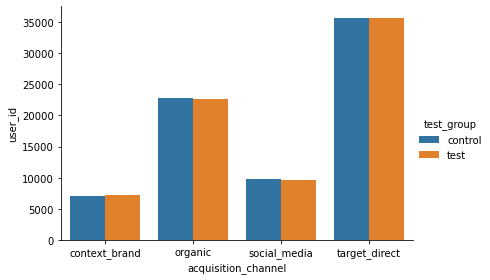

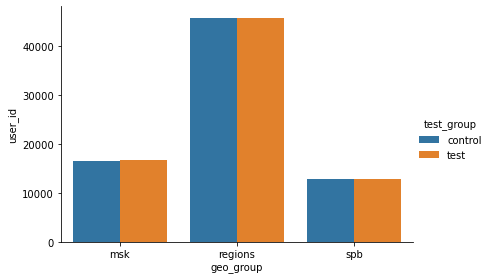

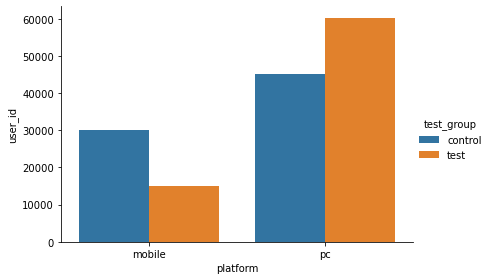

In [54]:
plot_segment_distribution(data, ['acquisition_channel', 'geo_group', 'platform'], "test_group")


С каналами привлечения и гео-группами система сплитования работает хорошо, но по типу платформы количество в контрольной группе сильно отличается от тестовой.

## Используем критерий Хи-квадрат для конверсии


Хи-квадрат — критерий, который подходит для оценки конверии, поскольку данные конверсии дискретные: пользователь либо совершил покупку, и мы присвоили ему 1, либо не совершил и мы присвоили ему 0.

Т.к. тест уже завершен, проанализируем общие результаты и сравним их с результатами для пользователей, зашедших с разных платформ, чтобы уменьшить риск принятия ошибочного решения. Поэтому дальше мы будем анализировать параллельно 3 теста:

1. Все пользователи, попавшие в тест
2. Пользователи, заходившие с ПК `platform = 'pc'`
3. Пользователи, заходившие с мобильного `platform = 'mobile'`

**1. Создаем для каждой из 3 групп теста отдельную таблицу с метриками**
   - общее количество пользователей 
   - количество покупок в окне конверсии
   - средняя сумма покупки 
   - конверсия (количество покупок в окне конверсии / общее количество пользователей или среднее по полю `within_window`)

In [56]:
metrics = data.groupby('test_group', as_index = False).agg({'user_id': 'count', \
                                                           'within_window': 'sum', \
                                                           'purchase_amount': 'mean'})

metrics['conversation'] = metrics['within_window']/metrics['user_id']*100
metrics

,test_group,user_id,within_window,purchase_amount,conversation
0,control,75210,22998,5170.864335,30.578381
1,test,75273,24427,5394.771589,32.451211


In [57]:
metrics_pc = data.loc[data['platform'] == 'pc'].groupby('test_group', as_index = False).agg({'user_id': 'count', \
                                                           'within_window': 'sum', \
                                                           'purchase_amount': 'mean'})
metrics_pc['conversation'] = metrics_pc['within_window']/metrics_pc['user_id']*100

metrics_pc

,test_group,user_id,within_window,purchase_amount,conversation
0,control,45112,13732,5200.121803,30.439794
1,test,60317,19659,5401.003720,32.592801


In [58]:
metrics_mobile = data.loc[data['platform'] == 'mobile'].groupby('test_group', as_index = False).agg({'user_id': 'count', \
                                                           'within_window': 'sum', \
                                                           'purchase_amount': 'mean'})
metrics_mobile['conversation'] = metrics_mobile['within_window']/metrics_mobile['user_id']*100
metrics_mobile

,test_group,user_id,within_window,purchase_amount,conversation
0,control,30098,9266,5127.505438,30.786099
1,test,14956,4768,5369.075812,31.880182


**2. Вычислим** `p-value` **для каждой группы с помощью теста хи-квадрат**

In [18]:
chi2stat, pval, table =  proportion.proportions_chisquare(metrics['within_window'], metrics['user_id'])

In [19]:
chi2stat_pc, pval_pc, table_pc = proportion.proportions_chisquare(metrics_pc['within_window'], metrics_pc['user_id'])

In [20]:
chi2stat_mobile, pval_mobile, table_mobile = proportion.proportions_chisquare(metrics_mobile['within_window'], metrics_mobile['user_id'])

**3. Введем в анализ уровень значимости в 5% с помощью переменной** `alpha`.


In [60]:
alpha = 0.05

In [61]:
print(pval < alpha)

True


In [62]:
print(pval_pc < alpha)


True


In [63]:
print(pval_mobile < alpha)


True


Т.к. p-value меньше уровня значимости, можем зафиксировать статистически значимую разницу и отклонить нулевую гипотезу.

## Вычислим мощность теста

**1. Присвоим функцию `GofChisquarePower()` в переменную `chipower`** 

In [26]:
chipower = smp.GofChisquarePower()

#### 2. Реализуем функцию для подсчета `effect_size`

`effect_size` — это та самая наблюдаемая разница между двумя вариантами. Вычисляется следующим образом: 

$$ES = \sqrt{(p_0 - p_1)^2/p_o}$$

, где под $p_0$ можно понимать конверсию в контрольной группе, а $p_1$ — тестовой

In [27]:
def chi2_effect_size(p0, p1):
    return np.sqrt(((p0 - p1)**2 / p0))

**3. Запишем значения конверсии в тестовой `conversion_test` и контрольной `conversion_control` группы в разные переменные.** 

**4. Создадим переменную nobs для количества наблюдений и запишем в нее значение меньшей группы.**

In [28]:
conversion_control = metrics['conversation'].values[0]/100 
conversion_test = metrics['conversation'].values[1]/100
nobs = min(metrics['user_id'])

In [29]:
conversion_control_mobile = metrics_mobile['conversation'].values[0]/100 
conversion_test_mobile = metrics_mobile['conversation'].values[1]/100 
nobs_mobile = min(metrics_mobile['user_id'])

In [30]:
conversion_control_pc = metrics_pc['conversation'].values[0]/100 
conversion_test_pc = metrics_pc['conversation'].values[1]/100 
nobs_pc = min(metrics_pc['user_id'])

**5. Вызовем функцию .solve_power и передадим ей в аргументы** 
    - effect_size
    - количество наблюдений меньшей группы
    - значение p-value
    - мощности присвой значение None

In [65]:
power = chipower.solve_power(effect_size = chi2_effect_size(conversion_control, conversion_test), 
                            nobs = nobs, alpha = pval , power = None)
power

0.9290939440556412

In [66]:
mobile_power = chipower.solve_power(effect_size = chi2_effect_size(conversion_control_mobile, conversion_test_mobile), 
                            nobs = nobs_mobile, alpha = pval_mobile , power = None)
mobile_power

0.5199383109433952

In [67]:
pc_power = chipower.solve_power(effect_size = chi2_effect_size(conversion_control_pc, conversion_test_pc), 
                            nobs = nobs_pc, alpha = pval_pc , power = None)
pc_power

0.8032102103432757

при стандартной мощности >= 0.8 мощность мобильных устройств достаточно низкая: с вероятностью более чем в 52% мы бы не увидели стат. значимых различий там, где они существуют.

## Воспользуемся бутстрапом для оценки влияния теста на средний чек

In [34]:
!pip install bootstrapped


[notice] A new release of pip available: 22.1.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [36]:
test = data[data['test_group'] == 'test']['purchase_amount'].dropna().values 
ctrl = data[data['test_group'] == 'control']['purchase_amount'].dropna().values

test_pc = data[(data['test_group'] == 'test') & (data['platform'] == 'pc')]['purchase_amount'].dropna().values 
control_pc = data[(data['test_group'] == 'control') & (data['platform'] == 'pc')]['purchase_amount'].dropna().values 

test_mobile = data[(data['test_group'] == 'test') & (data['platform'] == 'mobile')]['purchase_amount'].dropna().values 
control_mobile = data[(data['test_group'] == 'control') & (data['platform'] == 'mobile')]['purchase_amount'].dropna().values 

**1. Вызовем функцию `bootstrap_ab` для каждого сегмента**

In [69]:
boot = bs.bootstrap_ab(test = test, ctrl = ctrl
                              , stat_func = bs_stats.mean
                              , compare_func = bs_compare.difference
                              , return_distribution=True)

In [70]:
boot

array([213.43106111, 172.54267206, 182.95312151, ..., 145.9992096 ,
       265.85658331, 198.83195806])

In [71]:
boot_pc = bs.bootstrap_ab(test = test_pc, ctrl = control_pc
                              , stat_func = bs_stats.mean
                              , compare_func = bs_compare.difference
                              , return_distribution=True)


In [72]:
boot_pc

array([220.7589726 , 151.16691495, 139.29122056, ..., 133.21804853,
       123.72530453, 184.86803522])

In [73]:
boot_mobile = bs.bootstrap_ab(test = test_mobile, ctrl = control_mobile
                              , stat_func = bs_stats.mean
                              , compare_func = bs_compare.difference
                              , return_distribution=True)


In [74]:
boot_mobile

array([265.03885562, 386.04808072, 456.48204672, ..., 296.66538247,
       179.06116438, 244.57374203])

**2. Зададим размер доверительного интервала для каждого исследуемого сегмента 95% с помощью перцентилей**

In [75]:
borders = np.percentile(boot, [2.5, 97.5])
borders

array([144.12687102, 305.72290475])

In [76]:
borders_pc = np.percentile(boot_pc, [2.5, 97.5])
borders_pc

array([104.35668543, 297.44912643])

In [77]:
borders_mobile = np.percentile(boot_mobile, [2.5, 97.5])
borders_mobile

array([ 88.31702956, 395.66278663])

**3. Оценим, есть ли статистически значимое изменение по среднему чеку в каждом сегменте**

C:\Users\1645295\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


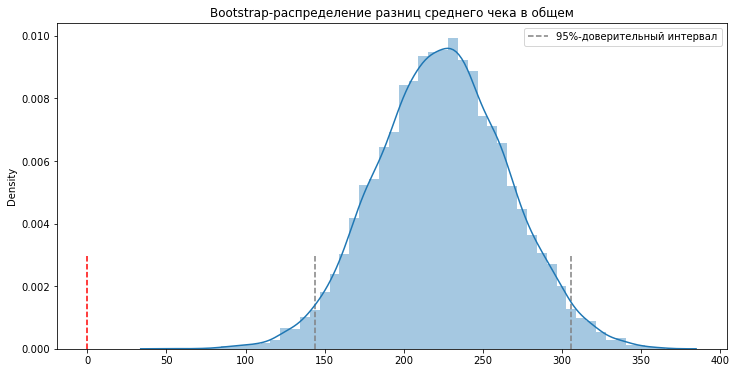

In [78]:
sns.distplot(boot) # функция построения распределения
plt.title('Bootstrap-распределение разниц среднего чека в общем')
plt.rcParams["figure.figsize"] = (12, 6)
plt.vlines(0, # отрисуем линию на уровне ноля
           ymin = 0, 
           ymax = 0.003, 
           linestyles= '--', 
           colors = 'red')
plt.vlines(borders, # отрисуем перцентили
           ymin = 0, 
           ymax = 0.003, 
           linestyles= '--', 
           colors = 'grey', 
           label = '95%-доверительный интервал')
plt.legend()
plt.show()

C:\Users\1645295\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


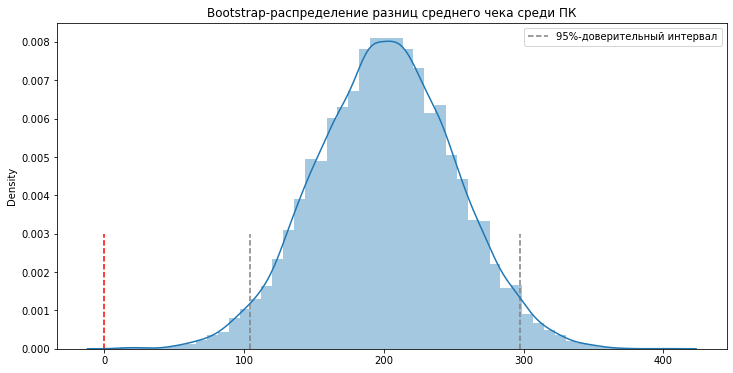

In [79]:
sns.distplot(boot_pc) # функция построения распределения
plt.title('Bootstrap-распределение разниц среднего чека среди ПК')
plt.rcParams["figure.figsize"] = (12, 6)
plt.vlines(0, # отрисуем линию на уровне ноля
           ymin = 0, 
           ymax = 0.003, 
           linestyles= '--', 
           colors = 'red')
plt.vlines(borders_pc, # отрисуем перцентили
           ymin = 0, 
           ymax = 0.003, 
           linestyles= '--', 
           colors = 'grey', 
           label = '95%-доверительный интервал')
plt.legend()
plt.show()

C:\Users\1645295\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


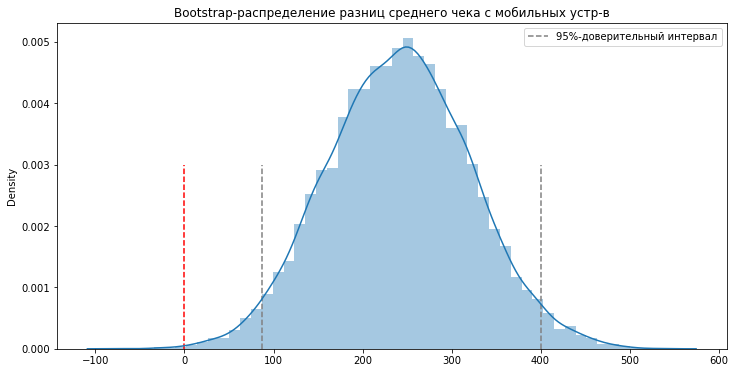

In [48]:
sns.distplot(boot_mobile) # функция построения распределения
plt.title('Bootstrap-распределение разниц среднего чека с мобильных устр-в')
plt.rcParams["figure.figsize"] = (12, 6)
plt.vlines(0, # отрисуем линию на уровне ноля
           ymin = 0, 
           ymax = 0.003, 
           linestyles= '--', 
           colors = 'red')
plt.vlines(borders_mobile, # отрисуем перцентили
           ymin = 0, 
           ymax = 0.003, 
           linestyles= '--', 
           colors = 'grey', 
           label = '95%-доверительный интервал')
plt.legend()
plt.show()

Т.к. 0 не входит в 95%-доверительный интервал и находится слева от него, метрика стат. значимо выросла.